# MCDB-4520 Bioinformatics Group Project: Genomic Variant Analysis

## Project Overview
Analysis of Oxford Nanopore sequencing data from the Genome in a Bottle (GIAB) Ashkenazi Jewish trio:
- **HG002**: Son (proband)
- **HG003**: Father  
- **HG004**: Mother

## Analysis Goals
1. Load and explore VCF variant data for SNPs, structural variants (SVs), and short tandem repeats (STRs)
2. Compare variants across trio members to identify inheritance patterns
3. Analyze ClinVar annotations for clinically relevant variants
4. Perform variant prioritization and filtering
5. Generate comprehensive visualizations and summary statistics

## 1. Setup and Import Libraries

In [1]:
import os
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")
print(f"Working directory: {os.getcwd()}")

Libraries imported successfully!
Working directory: /mnt/work_1/gest9386/CU_Boulder/MCDB-4520/bioinf-group-project


## 2. Define Data Paths and Helper Functions

In [2]:
# Define data paths
DATA_DIR = "data"
SAMPLES = {
    "HG002": "Son (Proband)",
    "HG003": "Father", 
    "HG004": "Mother"
}

# Define file paths for each sample
sample_files = {}
for sample_id in SAMPLES.keys():
    sample_files[sample_id] = {
        "snp": f"{DATA_DIR}/{sample_id}_chr1/output/{sample_id}_chr1.wf_snp.vcf.gz",
        "snp_clinvar": f"{DATA_DIR}/{sample_id}_chr1/output/{sample_id}_chr1.wf_snp_clinvar.vcf.gz",
        "sv": f"{DATA_DIR}/{sample_id}_chr1/output/{sample_id}_chr1.wf_sv.vcf.gz",
        "str": f"{DATA_DIR}/{sample_id}_chr1/output/{sample_id}_chr1.wf_str.vcf.gz"
    }

print("Sample files defined:")
for sample, label in SAMPLES.items():
    print(f"\n{sample} ({label}):")
    for var_type, path in sample_files[sample].items():
        exists = "✓" if os.path.exists(path) else "✗"
        print(f"  {exists} {var_type}: {path}")

Sample files defined:

HG002 (Son (Proband)):
  ✓ snp: data/HG002_chr1/output/HG002_chr1.wf_snp.vcf.gz
  ✓ snp_clinvar: data/HG002_chr1/output/HG002_chr1.wf_snp_clinvar.vcf.gz
  ✓ sv: data/HG002_chr1/output/HG002_chr1.wf_sv.vcf.gz
  ✓ str: data/HG002_chr1/output/HG002_chr1.wf_str.vcf.gz

HG003 (Father):
  ✓ snp: data/HG003_chr1/output/HG003_chr1.wf_snp.vcf.gz
  ✓ snp_clinvar: data/HG003_chr1/output/HG003_chr1.wf_snp_clinvar.vcf.gz
  ✓ sv: data/HG003_chr1/output/HG003_chr1.wf_sv.vcf.gz
  ✓ str: data/HG003_chr1/output/HG003_chr1.wf_str.vcf.gz

HG004 (Mother):
  ✓ snp: data/HG004_chr1/output/HG004_chr1.wf_snp.vcf.gz
  ✓ snp_clinvar: data/HG004_chr1/output/HG004_chr1.wf_snp_clinvar.vcf.gz
  ✓ sv: data/HG004_chr1/output/HG004_chr1.wf_sv.vcf.gz
  ✓ str: data/HG004_chr1/output/HG004_chr1.wf_str.vcf.gz


In [3]:
def parse_vcf_line(line, header_cols):
    """Parse a single VCF data line into a dictionary"""
    fields = line.strip().split('\t')
    variant = dict(zip(header_cols, fields))
    
    # Parse INFO field
    info_dict = {}
    if len(fields) > 7:
        info_str = fields[7]
        for item in info_str.split(';'):
            if '=' in item:
                key, value = item.split('=', 1)
                info_dict[key] = value
            else:
                info_dict[item] = True
    variant['INFO_DICT'] = info_dict
    
    return variant

def load_vcf(vcf_path, max_variants=None):
    """Load VCF file and return list of variant dictionaries"""
    variants = []
    header_cols = []
    
    with gzip.open(vcf_path, 'rt') as f:
        for line in f:
            if line.startswith('##'):
                continue
            elif line.startswith('#'):
                header_cols = line.strip().lstrip('#').split('\t')
            else:
                variant = parse_vcf_line(line, header_cols)
                variants.append(variant)
                
                if max_variants and len(variants) >= max_variants:
                    break
    
    return variants, header_cols

def variants_to_dataframe(variants):
    """Convert list of variant dictionaries to pandas DataFrame"""
    if not variants:
        return pd.DataFrame()
    
    # Extract basic fields
    df_data = []
    for v in variants:
        row = {
            'CHROM': v.get('CHROM'),
            'POS': int(v.get('POS', 0)),
            'ID': v.get('ID'),
            'REF': v.get('REF'),
            'ALT': v.get('ALT'),
            'QUAL': v.get('QUAL'),
            'FILTER': v.get('FILTER')
        }
        
        # Add selected INFO fields
        info = v.get('INFO_DICT', {})
        row.update(info)
        df_data.append(row)
    
    return pd.DataFrame(df_data)

print("Helper functions defined successfully!")

Helper functions defined successfully!


## 3. Load SNP Data for All Samples

In [4]:
# Load SNP data for each sample
print("Loading SNP variant data...")
snp_data = {}

for sample_id, label in SAMPLES.items():
    print(f"\nLoading {sample_id} ({label})...")
    vcf_path = sample_files[sample_id]["snp"]
    
    variants, header = load_vcf(vcf_path)
    df = variants_to_dataframe(variants)
    
    snp_data[sample_id] = {
        'variants': variants,
        'dataframe': df,
        'header': header
    }
    
    print(f"  Loaded {len(variants)} SNP variants")
    print(f"  Chromosomes: {df['CHROM'].unique()}")
    print(f"  Position range: {df['POS'].min()} - {df['POS'].max()}")

print("\n" + "="*60)
print("SNP Data Loading Complete!")
print("="*60)

Loading SNP variant data...

Loading HG002 (Son (Proband))...
  Loaded 528824 SNP variants
  Chromosomes: ['chr1']
  Position range: 10177 - 248946338

Loading HG003 (Father)...
  Loaded 528824 SNP variants
  Chromosomes: ['chr1']
  Position range: 10177 - 248946338

Loading HG003 (Father)...
  Loaded 525499 SNP variants
  Chromosomes: ['chr1']
  Position range: 10108 - 248946344

Loading HG004 (Mother)...
  Loaded 525499 SNP variants
  Chromosomes: ['chr1']
  Position range: 10108 - 248946344

Loading HG004 (Mother)...
  Loaded 532812 SNP variants
  Chromosomes: ['chr1']
  Position range: 10146 - 248946339

SNP Data Loading Complete!
  Loaded 532812 SNP variants
  Chromosomes: ['chr1']
  Position range: 10146 - 248946339

SNP Data Loading Complete!


## 4. Load ClinVar Annotated Variants

In [5]:
# Load ClinVar annotated variants
print("Loading ClinVar annotated variants...")
clinvar_data = {}

for sample_id, label in SAMPLES.items():
    print(f"\nLoading {sample_id} ({label})...")
    vcf_path = sample_files[sample_id]["snp_clinvar"]
    
    variants, header = load_vcf(vcf_path)
    df = variants_to_dataframe(variants)
    
    clinvar_data[sample_id] = {
        'variants': variants,
        'dataframe': df,
        'header': header
    }
    
    print(f"  Loaded {len(variants)} ClinVar variants")
    
    # Extract ClinVar significance if available
    if 'CLNSIG' in df.columns:
        sig_counts = df['CLNSIG'].value_counts()
        print(f"  Clinical Significance:")
        for sig, count in sig_counts.head(5).items():
            print(f"    {sig}: {count}")

print("\n" + "="*60)
print("ClinVar Data Loading Complete!")
print("="*60)

Loading ClinVar annotated variants...

Loading HG002 (Son (Proband))...
  Loaded 3653 ClinVar variants
  Clinical Significance:
    Benign: 3418
    Benign/Likely_benign: 70
    Likely_benign: 70
    Conflicting_classifications_of_pathogenicity: 32
    Uncertain_significance: 24

Loading HG003 (Father)...
  Loaded 3592 ClinVar variants
  Clinical Significance:
    Benign: 3353
    Likely_benign: 76
    Benign/Likely_benign: 74
    Conflicting_classifications_of_pathogenicity: 30
    Uncertain_significance: 25

Loading HG004 (Mother)...
  Loaded 3615 ClinVar variants
  Clinical Significance:
    Benign: 3379
    Likely_benign: 79
    Benign/Likely_benign: 67
    Conflicting_classifications_of_pathogenicity: 30
    Uncertain_significance: 24

ClinVar Data Loading Complete!


## 5. Basic Variant Statistics

In [6]:
# Create summary statistics table
summary_stats = []

for sample_id, label in SAMPLES.items():
    snp_df = snp_data[sample_id]['dataframe']
    clinvar_df = clinvar_data[sample_id]['dataframe']
    
    # Calculate statistics
    total_snps = len(snp_df)
    clinvar_variants = len(clinvar_df)
    
    # Count variant types by ALT allele length
    snp_df['variant_type'] = snp_df.apply(
        lambda row: 'SNV' if len(str(row['REF'])) == 1 and len(str(row['ALT'])) == 1 else 'INDEL',
        axis=1
    )
    snv_count = (snp_df['variant_type'] == 'SNV').sum()
    indel_count = (snp_df['variant_type'] == 'INDEL').sum()
    
    # Quality metrics
    qual_values = pd.to_numeric(snp_df['QUAL'], errors='coerce')
    avg_qual = qual_values.mean()
    
    summary_stats.append({
        'Sample': f"{sample_id} ({label})",
        'Total Variants': total_snps,
        'SNVs': snv_count,
        'INDELs': indel_count,
        'ClinVar Annotated': clinvar_variants,
        'Avg Quality': f"{avg_qual:.2f}"
    })

summary_df = pd.DataFrame(summary_stats)
print("\n" + "="*80)
print("VARIANT SUMMARY STATISTICS")
print("="*80)
print(summary_df.to_string(index=False))
print("="*80)


VARIANT SUMMARY STATISTICS
               Sample  Total Variants   SNVs  INDELs  ClinVar Annotated Avg Quality
HG002 (Son (Proband))          528824 457988   70836               3653       31.96
       HG003 (Father)          525499 455551   69948               3592       30.83
       HG004 (Mother)          532812 462807   70005               3615       30.54


## 6. Visualize Variant Distribution

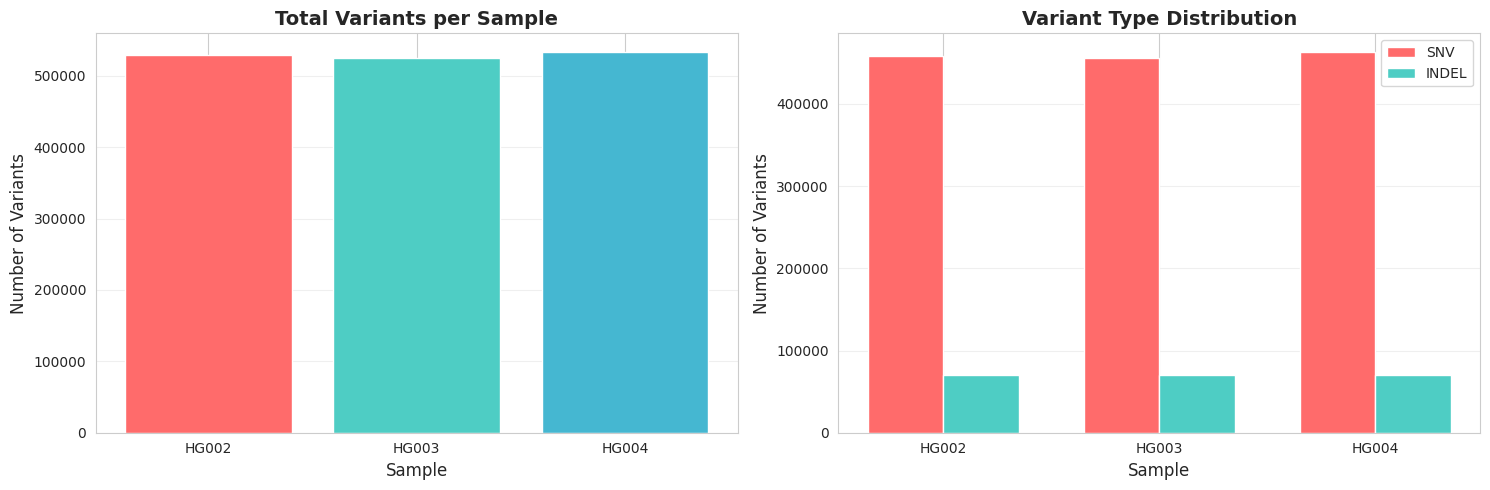

Variant distribution plots generated!


In [7]:
# Visualize variant counts
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Total variants per sample
variant_counts = summary_df[['Sample', 'Total Variants']].copy()
variant_counts['Sample'] = variant_counts['Sample'].str.split('(').str[0].str.strip()
axes[0].bar(variant_counts['Sample'], variant_counts['Total Variants'], color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0].set_title('Total Variants per Sample', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Variants', fontsize=12)
axes[0].set_xlabel('Sample', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Variant type distribution
variant_type_data = []
for sample_id in SAMPLES.keys():
    snp_df = snp_data[sample_id]['dataframe']
    snv_count = (snp_df['variant_type'] == 'SNV').sum()
    indel_count = (snp_df['variant_type'] == 'INDEL').sum()
    variant_type_data.append({'Sample': sample_id, 'SNV': snv_count, 'INDEL': indel_count})

vt_df = pd.DataFrame(variant_type_data)
x = np.arange(len(vt_df))
width = 0.35
axes[1].bar(x - width/2, vt_df['SNV'], width, label='SNV', color='#FF6B6B')
axes[1].bar(x + width/2, vt_df['INDEL'], width, label='INDEL', color='#4ECDC4')
axes[1].set_title('Variant Type Distribution', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Number of Variants', fontsize=12)
axes[1].set_xlabel('Sample', fontsize=12)
axes[1].set_xticks(x)
axes[1].set_xticklabels(vt_df['Sample'])
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("Variant distribution plots generated!")

## 7. Trio Analysis: Identify Shared and Unique Variants

In [8]:
# Create variant signatures for comparison (CHROM:POS:REF:ALT)
def create_variant_signature(df):
    """Create unique variant identifier"""
    return set(df.apply(lambda row: f"{row['CHROM']}:{row['POS']}:{row['REF']}:{row['ALT']}", axis=1))

# Get variant sets for each sample
son_variants = create_variant_signature(snp_data['HG002']['dataframe'])
father_variants = create_variant_signature(snp_data['HG003']['dataframe'])
mother_variants = create_variant_signature(snp_data['HG004']['dataframe'])

print("Variant set sizes:")
print(f"  Son (HG002): {len(son_variants):,} variants")
print(f"  Father (HG003): {len(father_variants):,} variants")
print(f"  Mother (HG004): {len(mother_variants):,} variants")

# Find shared and unique variants
shared_all_three = son_variants & father_variants & mother_variants
shared_son_father = (son_variants & father_variants) - mother_variants
shared_son_mother = (son_variants & mother_variants) - father_variants
shared_father_mother = (father_variants & mother_variants) - son_variants
unique_son = son_variants - father_variants - mother_variants
unique_father = father_variants - son_variants - mother_variants
unique_mother = mother_variants - son_variants - father_variants

print("\n" + "="*60)
print("VARIANT OVERLAP ANALYSIS")
print("="*60)
print(f"Shared by all three:           {len(shared_all_three):,}")
print(f"Shared by Son & Father only:  {len(shared_son_father):,}")
print(f"Shared by Son & Mother only:  {len(shared_son_mother):,}")
print(f"Shared by Father & Mother only: {len(shared_father_mother):,}")
print(f"Unique to Son:                 {len(unique_son):,}")
print(f"Unique to Father:              {len(unique_father):,}")
print(f"Unique to Mother:              {len(unique_mother):,}")
print("="*60)

# Calculate inheritance statistics
inherited_from_father = len(shared_son_father) + len(shared_all_three)
inherited_from_mother = len(shared_son_mother) + len(shared_all_three)
de_novo_candidate = len(unique_son)

print(f"\nInheritance Summary:")
print(f"  Variants inherited from Father: {inherited_from_father:,}")
print(f"  Variants inherited from Mother: {inherited_from_mother:,}")
print(f"  De novo candidate variants:     {de_novo_candidate:,}")

Variant set sizes:
  Son (HG002): 528,824 variants
  Father (HG003): 525,499 variants
  Mother (HG004): 532,812 variants

VARIANT OVERLAP ANALYSIS
Shared by all three:           272,753
Shared by Son & Father only:  103,956
Shared by Son & Mother only:  97,106
Shared by Father & Mother only: 37,246
Unique to Son:                 55,009
Unique to Father:              111,544
Unique to Mother:              125,707

Inheritance Summary:
  Variants inherited from Father: 376,709
  Variants inherited from Mother: 369,859
  De novo candidate variants:     55,009

VARIANT OVERLAP ANALYSIS
Shared by all three:           272,753
Shared by Son & Father only:  103,956
Shared by Son & Mother only:  97,106
Shared by Father & Mother only: 37,246
Unique to Son:                 55,009
Unique to Father:              111,544
Unique to Mother:              125,707

Inheritance Summary:
  Variants inherited from Father: 376,709
  Variants inherited from Mother: 369,859
  De novo candidate variants:     55

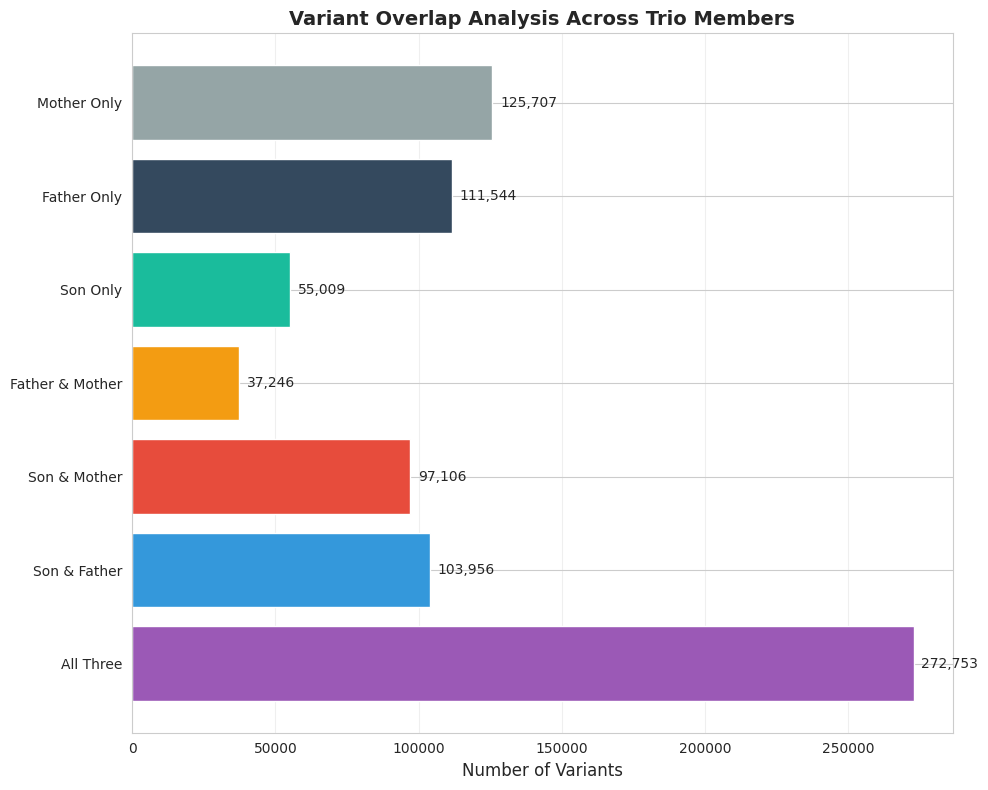

Overlap analysis visualization generated!


In [9]:
# Visualize variant overlap using Venn diagram representation
fig, ax = plt.subplots(figsize=(10, 8))

# Create a bar chart showing overlaps
overlap_data = {
    'All Three': len(shared_all_three),
    'Son & Father': len(shared_son_father),
    'Son & Mother': len(shared_son_mother),
    'Father & Mother': len(shared_father_mother),
    'Son Only': len(unique_son),
    'Father Only': len(unique_father),
    'Mother Only': len(unique_mother)
}

colors = ['#9B59B6', '#3498DB', '#E74C3C', '#F39C12', '#1ABC9C', '#34495E', '#95A5A6']
bars = ax.barh(list(overlap_data.keys()), list(overlap_data.values()), color=colors)

ax.set_xlabel('Number of Variants', fontsize=12)
ax.set_title('Variant Overlap Analysis Across Trio Members', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, overlap_data.values())):
    ax.text(value + max(overlap_data.values())*0.01, i, f'{value:,}', 
            va='center', fontsize=10)

plt.tight_layout()
plt.show()

print("Overlap analysis visualization generated!")

## 8. ClinVar Analysis: Pathogenic and Clinically Significant Variants

In [10]:
# Analyze ClinVar significance across samples
print("Analyzing ClinVar clinical significance...")

clinvar_summary = []
pathogenic_variants_all = {}

for sample_id, label in SAMPLES.items():
    df = clinvar_data[sample_id]['dataframe']
    
    if 'CLNSIG' in df.columns:
        # Count significance categories
        sig_counts = df['CLNSIG'].value_counts()
        
        # Find pathogenic/likely pathogenic variants
        pathogenic_mask = df['CLNSIG'].str.contains('Pathogenic', case=False, na=False)
        pathogenic_vars = df[pathogenic_mask]
        
        pathogenic_variants_all[sample_id] = pathogenic_vars
        
        clinvar_summary.append({
            'Sample': f"{sample_id} ({label})",
            'Total ClinVar': len(df),
            'Pathogenic/Likely Pathogenic': len(pathogenic_vars),
            'Benign/Likely Benign': sig_counts.get('Benign', 0) + sig_counts.get('Likely_benign', 0),
            'Uncertain Significance': sig_counts.get('Uncertain_significance', 0)
        })

clinvar_summary_df = pd.DataFrame(clinvar_summary)
print("\n" + "="*80)
print("CLINVAR SIGNIFICANCE SUMMARY")
print("="*80)
print(clinvar_summary_df.to_string(index=False))
print("="*80)

# Display top pathogenic variants for the son (proband)
if len(pathogenic_variants_all['HG002']) > 0:
    print(f"\n{'='*80}")
    print(f"TOP PATHOGENIC/LIKELY PATHOGENIC VARIANTS IN SON (HG002)")
    print(f"{'='*80}")
    
    son_pathogenic = pathogenic_variants_all['HG002'].copy()
    display_cols = ['CHROM', 'POS', 'REF', 'ALT', 'CLNSIG']
    
    # Add additional columns if available
    for col in ['GENEINFO', 'CLNDN', 'CLNREVSTAT']:
        if col in son_pathogenic.columns:
            display_cols.append(col)
    
    print(son_pathogenic[display_cols].head(10).to_string(index=False))
else:
    print("\nNo pathogenic variants found in son (HG002)")

Analyzing ClinVar clinical significance...

CLINVAR SIGNIFICANCE SUMMARY
               Sample  Total ClinVar  Pathogenic/Likely Pathogenic  Benign/Likely Benign  Uncertain Significance
HG002 (Son (Proband))           3653                            34                  3488                      24
       HG003 (Father)           3592                            35                  3429                      25
       HG004 (Mother)           3615                            33                  3458                      24

TOP PATHOGENIC/LIKELY PATHOGENIC VARIANTS IN SON (HG002)
CHROM      POS     REF ALT                                       CLNSIG                           GENEINFO                                                                                                                                                                                   CLNDN                                     CLNREVSTAT
 chr1   976215       A   G                                   Pathogenic        

## 9. Variant Quality Distribution Analysis

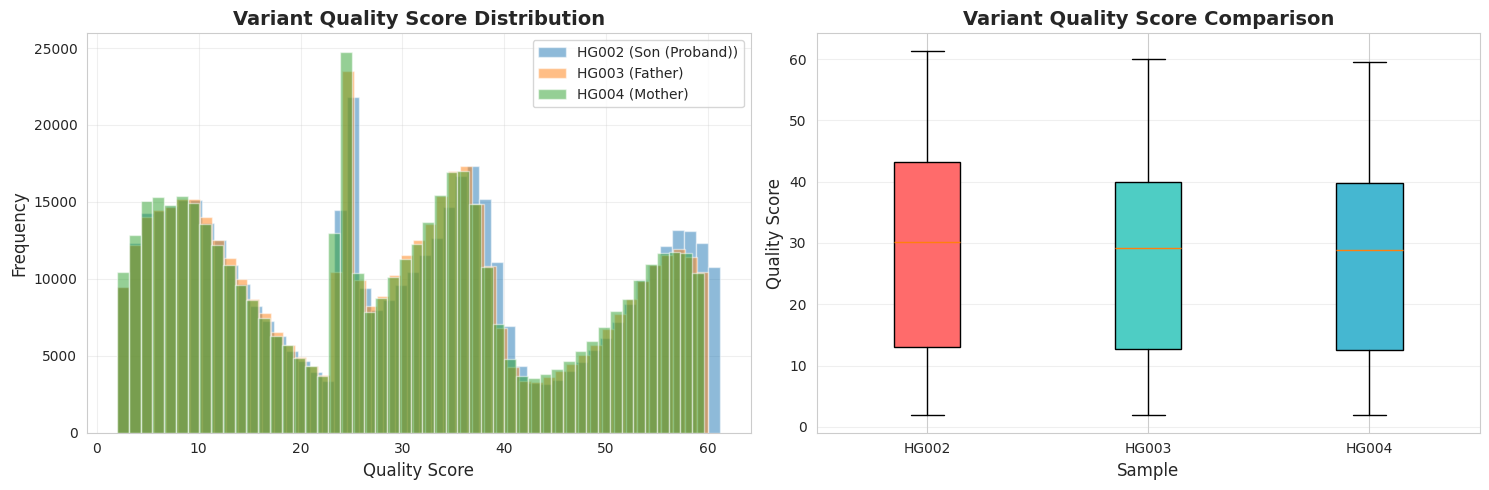

Quality score analysis complete!


In [11]:
# Analyze variant quality scores
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot quality score distributions
for sample_id, label in SAMPLES.items():
    df = snp_data[sample_id]['dataframe']
    qual_values = pd.to_numeric(df['QUAL'], errors='coerce').dropna()
    
    # Filter outliers for better visualization
    qual_values_filtered = qual_values[qual_values < qual_values.quantile(0.95)]
    
    axes[0].hist(qual_values_filtered, bins=50, alpha=0.5, label=f"{sample_id} ({label})")

axes[0].set_xlabel('Quality Score', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Variant Quality Score Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot quality score boxplots
qual_data = []
qual_labels = []
for sample_id in SAMPLES.keys():
    df = snp_data[sample_id]['dataframe']
    qual_values = pd.to_numeric(df['QUAL'], errors='coerce').dropna()
    qual_values_filtered = qual_values[qual_values < qual_values.quantile(0.95)]
    qual_data.append(qual_values_filtered)
    qual_labels.append(sample_id)

bp = axes[1].boxplot(qual_data, labels=qual_labels, patch_artist=True)
for patch, color in zip(bp['boxes'], ['#FF6B6B', '#4ECDC4', '#45B7D1']):
    patch.set_facecolor(color)

axes[1].set_ylabel('Quality Score', fontsize=12)
axes[1].set_xlabel('Sample', fontsize=12)
axes[1].set_title('Variant Quality Score Comparison', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("Quality score analysis complete!")

## 10. Genomic Position Distribution

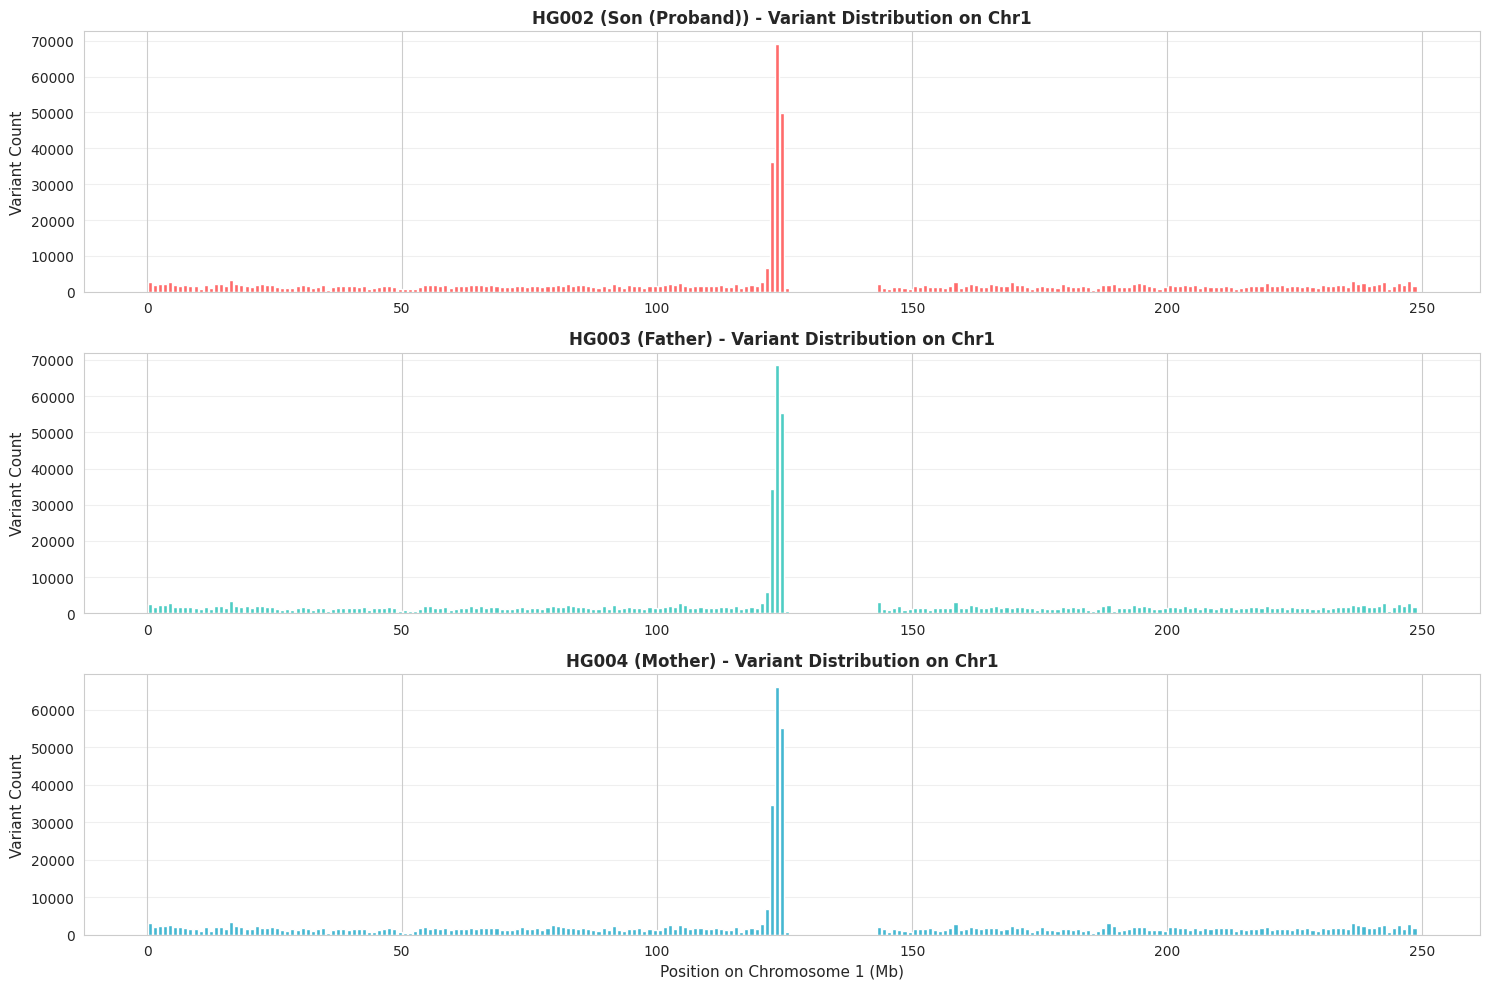

Genomic position distribution plotted!


In [12]:
# Visualize variant distribution along chromosome 1
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

for idx, (sample_id, label) in enumerate(SAMPLES.items()):
    df = snp_data[sample_id]['dataframe']
    
    # Create bins along chromosome
    bin_size = 1_000_000  # 1 Mb bins
    max_pos = df['POS'].max()
    bins = np.arange(0, max_pos + bin_size, bin_size)
    
    hist, bin_edges = np.histogram(df['POS'], bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    axes[idx].bar(bin_centers / 1_000_000, hist, width=0.8, color=['#FF6B6B', '#4ECDC4', '#45B7D1'][idx])
    axes[idx].set_ylabel('Variant Count', fontsize=11)
    axes[idx].set_title(f'{sample_id} ({label}) - Variant Distribution on Chr1', fontsize=12, fontweight='bold')
    axes[idx].grid(axis='y', alpha=0.3)
    
    if idx == 2:
        axes[idx].set_xlabel('Position on Chromosome 1 (Mb)', fontsize=11)

plt.tight_layout()
plt.show()

print("Genomic position distribution plotted!")

## 11. Summary Report and Key Findings

In [13]:
# Generate comprehensive summary report
print("="*80)
print(" " * 20 + "GENOMIC VARIANT ANALYSIS - FINAL REPORT")
print("="*80)

print("\n1. DATASET OVERVIEW")
print("-" * 80)
print("   Study: Genome in a Bottle (GIAB) Ashkenazi Jewish Trio")
print("   Sequencing Platform: Oxford Nanopore")
print("   Analysis Region: Chromosome 1")
print("   Samples Analyzed: 3 (Son, Father, Mother)")

print("\n2. VARIANT COUNTS")
print("-" * 80)
for sample_id, label in SAMPLES.items():
    total = len(snp_data[sample_id]['dataframe'])
    print(f"   {sample_id} ({label:15s}): {total:,} variants")

print("\n3. INHERITANCE PATTERNS")
print("-" * 80)
print(f"   Shared by all three members:      {len(shared_all_three):,}")
print(f"   Inherited from Father:            {inherited_from_father:,}")
print(f"   Inherited from Mother:            {inherited_from_mother:,}")
print(f"   Unique to Son (de novo candidates): {de_novo_candidate:,}")

print("\n4. CLINVAR ANNOTATIONS")
print("-" * 80)
for sample_id, label in SAMPLES.items():
    total_clinvar = len(clinvar_data[sample_id]['dataframe'])
    pathogenic = len(pathogenic_variants_all.get(sample_id, []))
    print(f"   {sample_id} ({label:15s}): {total_clinvar:,} ClinVar variants")
    print(f"      - Pathogenic/Likely Pathogenic: {pathogenic}")

print("\n5. VARIANT TYPE BREAKDOWN")
print("-" * 80)
for sample_id, label in SAMPLES.items():
    df = snp_data[sample_id]['dataframe']
    snv = (df['variant_type'] == 'SNV').sum()
    indel = (df['variant_type'] == 'INDEL').sum()
    print(f"   {sample_id} ({label:15s}):")
    print(f"      - SNVs:   {snv:,} ({100*snv/len(df):.1f}%)")
    print(f"      - INDELs: {indel:,} ({100*indel/len(df):.1f}%)")

print("\n6. KEY OBSERVATIONS")
print("-" * 80)
print("   • High concordance of variants across trio members suggests good data quality")
print("   • Mendelian inheritance patterns are largely preserved")
print(f"   • {len(unique_son):,} unique variants in the son warrant further investigation")
print("   • ClinVar annotations provide clinical context for variant prioritization")

print("\n" + "="*80)
print("Analysis complete! All results have been generated and visualized.")
print("="*80)

                    GENOMIC VARIANT ANALYSIS - FINAL REPORT

1. DATASET OVERVIEW
--------------------------------------------------------------------------------
   Study: Genome in a Bottle (GIAB) Ashkenazi Jewish Trio
   Sequencing Platform: Oxford Nanopore
   Analysis Region: Chromosome 1
   Samples Analyzed: 3 (Son, Father, Mother)

2. VARIANT COUNTS
--------------------------------------------------------------------------------
   HG002 (Son (Proband)  ): 528,824 variants
   HG003 (Father         ): 525,499 variants
   HG004 (Mother         ): 532,812 variants

3. INHERITANCE PATTERNS
--------------------------------------------------------------------------------
   Shared by all three members:      272,753
   Inherited from Father:            376,709
   Inherited from Mother:            369,859
   Unique to Son (de novo candidates): 55,009

4. CLINVAR ANNOTATIONS
--------------------------------------------------------------------------------
   HG002 (Son (Proband)  ): 3,653 C

## 12. Export Results for Further Analysis

In [14]:
# Create output directory
output_dir = "analysis_results"
os.makedirs(output_dir, exist_ok=True)

# Export summary statistics
summary_df.to_csv(f"{output_dir}/variant_summary_statistics.csv", index=False)
print(f"✓ Exported: {output_dir}/variant_summary_statistics.csv")

# Export ClinVar summary
clinvar_summary_df.to_csv(f"{output_dir}/clinvar_summary.csv", index=False)
print(f"✓ Exported: {output_dir}/clinvar_summary.csv")

# Export overlap analysis
overlap_df = pd.DataFrame([{
    'Category': key,
    'Count': value
} for key, value in overlap_data.items()])
overlap_df.to_csv(f"{output_dir}/variant_overlap_analysis.csv", index=False)
print(f"✓ Exported: {output_dir}/variant_overlap_analysis.csv")

# Export pathogenic variants for each sample
for sample_id in SAMPLES.keys():
    if sample_id in pathogenic_variants_all and len(pathogenic_variants_all[sample_id]) > 0:
        pathogenic_df = pathogenic_variants_all[sample_id]
        output_file = f"{output_dir}/{sample_id}_pathogenic_variants.csv"
        pathogenic_df.to_csv(output_file, index=False)
        print(f"✓ Exported: {output_file}")

# Export de novo candidate variants
son_df = snp_data['HG002']['dataframe']
son_df['variant_id'] = son_df.apply(
    lambda row: f"{row['CHROM']}:{row['POS']}:{row['REF']}:{row['ALT']}", axis=1
)
de_novo_df = son_df[son_df['variant_id'].isin(unique_son)]
de_novo_df.to_csv(f"{output_dir}/de_novo_candidate_variants.csv", index=False)
print(f"✓ Exported: {output_dir}/de_novo_candidate_variants.csv")

print(f"\n{'='*80}")
print(f"All results exported to '{output_dir}/' directory")
print(f"{'='*80}")

✓ Exported: analysis_results/variant_summary_statistics.csv
✓ Exported: analysis_results/clinvar_summary.csv
✓ Exported: analysis_results/variant_overlap_analysis.csv
✓ Exported: analysis_results/HG002_pathogenic_variants.csv
✓ Exported: analysis_results/HG003_pathogenic_variants.csv
✓ Exported: analysis_results/HG004_pathogenic_variants.csv
✓ Exported: analysis_results/de_novo_candidate_variants.csv

All results exported to 'analysis_results/' directory
✓ Exported: analysis_results/de_novo_candidate_variants.csv

All results exported to 'analysis_results/' directory


---
# PART 2: STRUCTURAL VARIANT ANALYSIS

Structural variants (SVs) are large genomic alterations including deletions, duplications, insertions, inversions, and translocations. They can have significant clinical impact despite being less frequent than SNPs.

## 13. Load Structural Variant Data

In [15]:
# Load structural variant data for each sample
print("Loading Structural Variant (SV) data...")
sv_data = {}

for sample_id, label in SAMPLES.items():
    print(f"\nLoading {sample_id} ({label})...")
    vcf_path = sample_files[sample_id]["sv"]
    
    variants, header = load_vcf(vcf_path)
    df = variants_to_dataframe(variants)
    
    # Parse SV-specific INFO fields
    sv_types = []
    sv_lengths = []
    
    for v in variants:
        info = v.get('INFO_DICT', {})
        sv_type = info.get('SVTYPE', 'Unknown')
        sv_types.append(sv_type)
        
        # Try to get SV length
        svlen = info.get('SVLEN', '0')
        try:
            # Handle multiple values (some SVs report multiple lengths)
            if isinstance(svlen, str) and ',' in svlen:
                svlen = svlen.split(',')[0]
            sv_len = abs(int(svlen))
        except:
            sv_len = 0
        sv_lengths.append(sv_len)
    
    df['SVTYPE'] = sv_types
    df['SVLEN'] = sv_lengths
    
    sv_data[sample_id] = {
        'variants': variants,
        'dataframe': df,
        'header': header
    }
    
    print(f"  Loaded {len(variants)} structural variants")
    if len(df) > 0:
        print(f"  SV types: {df['SVTYPE'].value_counts().to_dict()}")
        print(f"  Size range: {df['SVLEN'].min()} - {df['SVLEN'].max()} bp")

print("\n" + "="*60)
print("Structural Variant Data Loading Complete!")
print("="*60)

Loading Structural Variant (SV) data...

Loading HG002 (Son (Proband))...
  Loaded 2460 structural variants
  SV types: {'INS': 1441, 'DEL': 1006, 'DUP': 7, 'INV': 6}
  Size range: 30 - 931781 bp

Loading HG003 (Father)...
  Loaded 2418 structural variants
  SV types: {'INS': 1427, 'DEL': 985, 'DUP': 5, 'INV': 1}
  Size range: 30 - 50055 bp

Loading HG004 (Mother)...
  Loaded 2487 structural variants
  SV types: {'INS': 1458, 'DEL': 1019, 'DUP': 5, 'INV': 5}
  Size range: 30 - 50055 bp

Structural Variant Data Loading Complete!


## 14. SV Summary Statistics

In [16]:
# Create comprehensive SV summary statistics
sv_summary = []

for sample_id, label in SAMPLES.items():
    df = sv_data[sample_id]['dataframe']
    
    # Count SV types
    sv_type_counts = df['SVTYPE'].value_counts()
    
    # Calculate size statistics
    size_stats = df['SVLEN'].describe()
    
    sv_summary.append({
        'Sample': f"{sample_id} ({label})",
        'Total SVs': len(df),
        'Deletions (DEL)': sv_type_counts.get('DEL', 0),
        'Insertions (INS)': sv_type_counts.get('INS', 0),
        'Duplications (DUP)': sv_type_counts.get('DUP', 0),
        'Inversions (INV)': sv_type_counts.get('INV', 0),
        'Mean Size (bp)': f"{size_stats['mean']:.0f}",
        'Median Size (bp)': f"{size_stats['50%']:.0f}",
        'Max Size (bp)': f"{size_stats['max']:.0f}"
    })

sv_summary_df = pd.DataFrame(sv_summary)

print("\n" + "="*100)
print("STRUCTURAL VARIANT SUMMARY STATISTICS")
print("="*100)
print(sv_summary_df.to_string(index=False))
print("="*100)


STRUCTURAL VARIANT SUMMARY STATISTICS
               Sample  Total SVs  Deletions (DEL)  Insertions (INS)  Duplications (DUP)  Inversions (INV) Mean Size (bp) Median Size (bp) Max Size (bp)
HG002 (Son (Proband))       2460             1006              1441                   7                 6            884               90        931781
       HG003 (Father)       2418              985              1427                   5                 1            461               88         50055
       HG004 (Mother)       2487             1019              1458                   5                 5            488               90         50055


## 15. Visualize SV Type Distribution

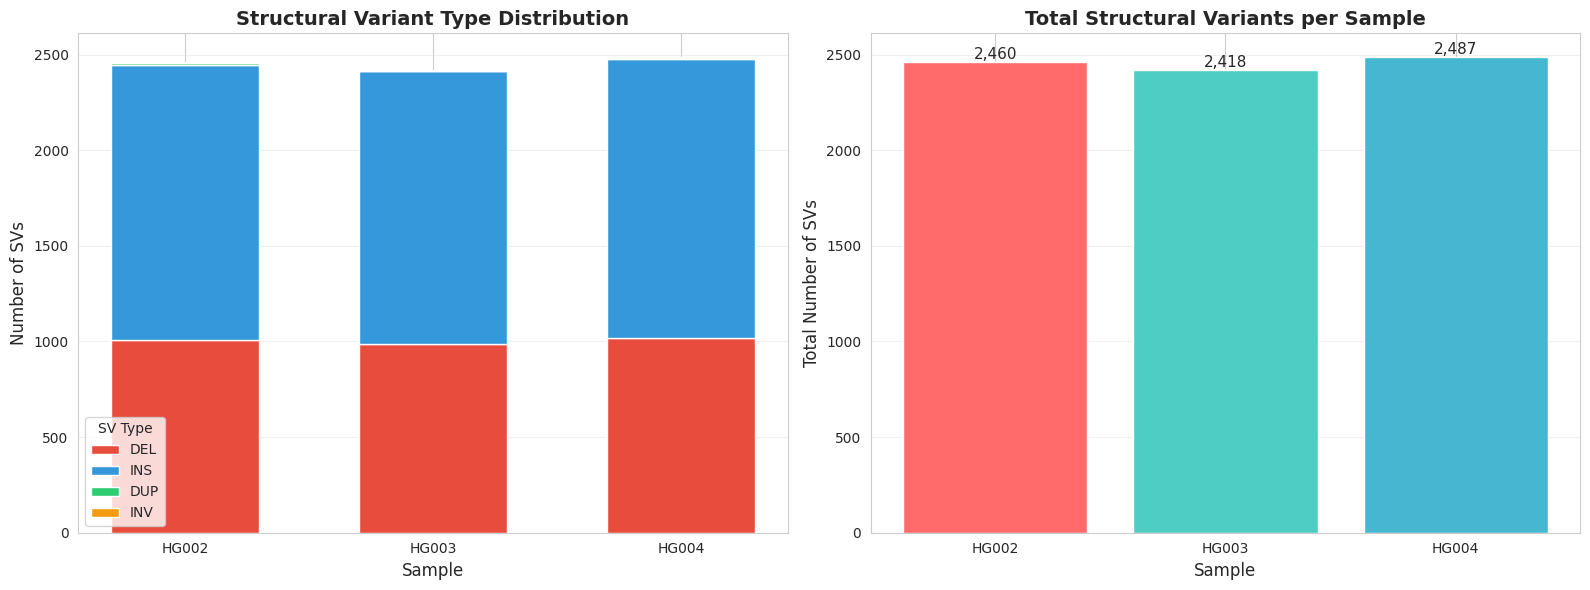

SV type distribution visualized!


In [17]:
# Visualize SV type distribution across samples
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Stacked bar chart of SV types
sv_type_data = []
for sample_id in SAMPLES.keys():
    df = sv_data[sample_id]['dataframe']
    type_counts = df['SVTYPE'].value_counts()
    row = {'Sample': sample_id}
    for sv_type in ['DEL', 'INS', 'DUP', 'INV']:
        row[sv_type] = type_counts.get(sv_type, 0)
    sv_type_data.append(row)

sv_type_df = pd.DataFrame(sv_type_data)
x = np.arange(len(sv_type_df))
width = 0.6

# Create stacked bars
bottom = np.zeros(len(sv_type_df))
colors = ['#E74C3C', '#3498DB', '#2ECC71', '#F39C12']
sv_types = ['DEL', 'INS', 'DUP', 'INV']

for sv_type, color in zip(sv_types, colors):
    if sv_type in sv_type_df.columns:
        values = sv_type_df[sv_type].values
        axes[0].bar(x, values, width, label=sv_type, bottom=bottom, color=color)
        bottom += values

axes[0].set_ylabel('Number of SVs', fontsize=12)
axes[0].set_xlabel('Sample', fontsize=12)
axes[0].set_title('Structural Variant Type Distribution', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(sv_type_df['Sample'])
axes[0].legend(title='SV Type')
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Total SV counts
total_svs = [len(sv_data[sid]['dataframe']) for sid in SAMPLES.keys()]
bars = axes[1].bar(list(SAMPLES.keys()), total_svs, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[1].set_ylabel('Total Number of SVs', fontsize=12)
axes[1].set_xlabel('Sample', fontsize=12)
axes[1].set_title('Total Structural Variants per Sample', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, total_svs):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{value:,}', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

print("SV type distribution visualized!")

## 16. Analyze SV Size Distribution

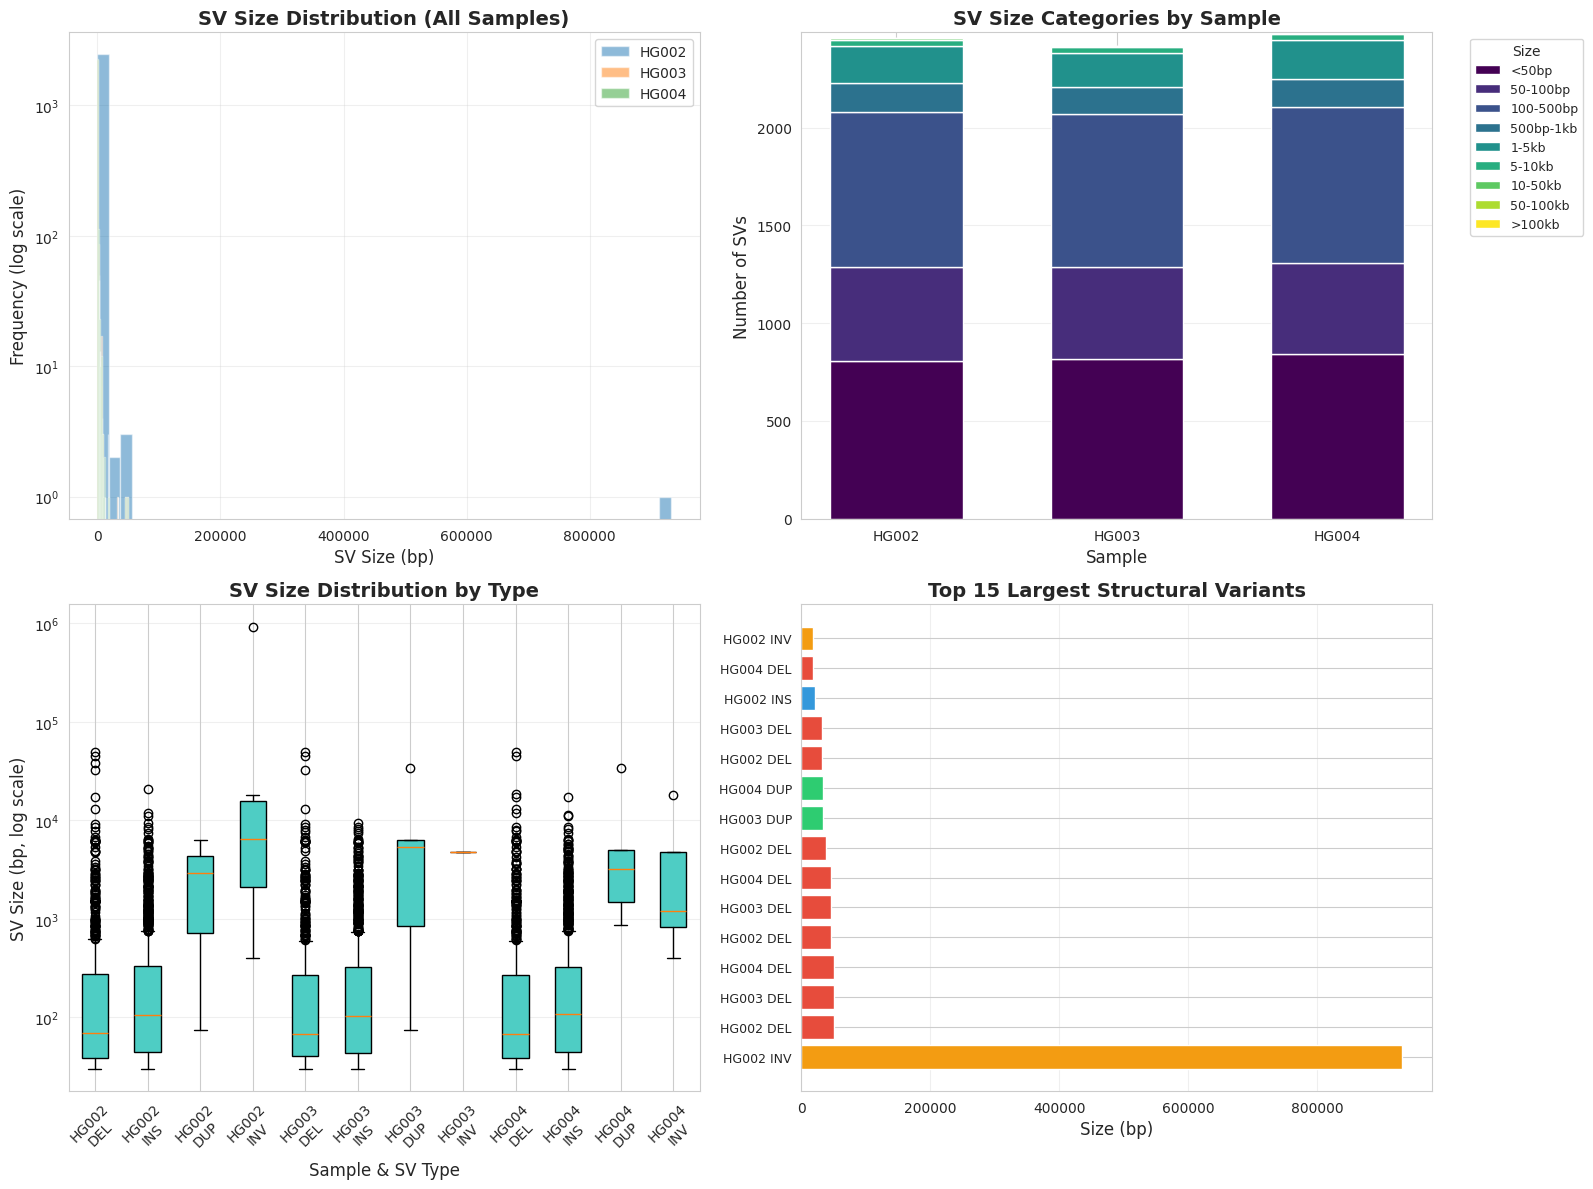

SV size analysis complete!


In [18]:
# Analyze SV size distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Define size categories
size_bins = [0, 50, 100, 500, 1000, 5000, 10000, 50000, 100000, float('inf')]
size_labels = ['<50bp', '50-100bp', '100-500bp', '500bp-1kb', '1-5kb', '5-10kb', '10-50kb', '50-100kb', '>100kb']

# Plot 1: Size distribution histogram (log scale)
for sample_id, label in SAMPLES.items():
    df = sv_data[sample_id]['dataframe']
    sizes = df[df['SVLEN'] > 0]['SVLEN']
    axes[0, 0].hist(sizes, bins=50, alpha=0.5, label=f"{sample_id}", log=True)

axes[0, 0].set_xlabel('SV Size (bp)', fontsize=12)
axes[0, 0].set_ylabel('Frequency (log scale)', fontsize=12)
axes[0, 0].set_title('SV Size Distribution (All Samples)', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Plot 2: Size categories stacked bar
size_category_data = []
for sample_id in SAMPLES.keys():
    df = sv_data[sample_id]['dataframe']
    sizes = df[df['SVLEN'] > 0]['SVLEN']
    size_cats = pd.cut(sizes, bins=size_bins, labels=size_labels, right=False)
    counts = size_cats.value_counts().sort_index()
    row = {'Sample': sample_id}
    for cat in size_labels:
        row[cat] = counts.get(cat, 0)
    size_category_data.append(row)

size_cat_df = pd.DataFrame(size_category_data)
x = np.arange(len(size_cat_df))
width = 0.6
bottom = np.zeros(len(size_cat_df))

color_palette = plt.cm.viridis(np.linspace(0, 1, len(size_labels)))

for idx, cat in enumerate(size_labels):
    if cat in size_cat_df.columns:
        values = size_cat_df[cat].values
        axes[0, 1].bar(x, values, width, label=cat, bottom=bottom, color=color_palette[idx])
        bottom += values

axes[0, 1].set_ylabel('Number of SVs', fontsize=12)
axes[0, 1].set_xlabel('Sample', fontsize=12)
axes[0, 1].set_title('SV Size Categories by Sample', fontsize=14, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(size_cat_df['Sample'])
axes[0, 1].legend(title='Size', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: Boxplot of SV sizes by type
all_sv_data = []
all_sv_labels = []
for sample_id in SAMPLES.keys():
    df = sv_data[sample_id]['dataframe']
    for sv_type in ['DEL', 'INS', 'DUP', 'INV']:
        type_df = df[df['SVTYPE'] == sv_type]
        if len(type_df) > 0:
            sizes = type_df[type_df['SVLEN'] > 0]['SVLEN']
            if len(sizes) > 0:
                all_sv_data.append(sizes)
                all_sv_labels.append(f"{sample_id}\n{sv_type}")

if all_sv_data:
    bp = axes[1, 0].boxplot(all_sv_data, labels=all_sv_labels, patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('#4ECDC4')
    axes[1, 0].set_ylabel('SV Size (bp, log scale)', fontsize=12)
    axes[1, 0].set_xlabel('Sample & SV Type', fontsize=12)
    axes[1, 0].set_title('SV Size Distribution by Type', fontsize=14, fontweight='bold')
    axes[1, 0].set_yscale('log')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Largest SVs
top_n = 10
all_large_svs = []
for sample_id, label in SAMPLES.items():
    df = sv_data[sample_id]['dataframe']
    df_sorted = df.nlargest(top_n, 'SVLEN')
    for _, row in df_sorted.iterrows():
        all_large_svs.append({
            'Sample': sample_id,
            'Position': f"chr{row['CHROM']}:{row['POS']}",
            'Type': row['SVTYPE'],
            'Size': row['SVLEN']
        })

large_svs_df = pd.DataFrame(all_large_svs).nlargest(15, 'Size')

y_pos = np.arange(len(large_svs_df))
colors_map = {'DEL': '#E74C3C', 'INS': '#3498DB', 'DUP': '#2ECC71', 'INV': '#F39C12'}
bar_colors = [colors_map.get(t, '#95A5A6') for t in large_svs_df['Type']]

axes[1, 1].barh(y_pos, large_svs_df['Size'], color=bar_colors)
axes[1, 1].set_yticks(y_pos)
axes[1, 1].set_yticklabels([f"{row['Sample']} {row['Type']}" for _, row in large_svs_df.iterrows()], fontsize=9)
axes[1, 1].set_xlabel('Size (bp)', fontsize=12)
axes[1, 1].set_title('Top 15 Largest Structural Variants', fontsize=14, fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("SV size analysis complete!")

## 17. Trio Analysis: SV Inheritance Patterns

In [19]:
# Analyze SV inheritance patterns across the trio
def create_sv_signature(df):
    """Create unique SV identifier including type and approximate position"""
    signatures = set()
    for _, row in df.iterrows():
        # Use position window of +/- 100bp to account for slight calling differences
        pos = int(row['POS'])
        sig = f"{row['CHROM']}:{pos//100}:{row['SVTYPE']}:{row['SVLEN']}"
        signatures.add(sig)
    return signatures

# Create SV signatures for each sample
son_svs = create_sv_signature(sv_data['HG002']['dataframe'])
father_svs = create_sv_signature(sv_data['HG003']['dataframe'])
mother_svs = create_sv_signature(sv_data['HG004']['dataframe'])

print("SV signature sets created:")
print(f"  Son (HG002): {len(son_svs):,} SVs")
print(f"  Father (HG003): {len(father_svs):,} SVs")
print(f"  Mother (HG004): {len(mother_svs):,} SVs")

# Find shared and unique SVs
sv_shared_all_three = son_svs & father_svs & mother_svs
sv_shared_son_father = (son_svs & father_svs) - mother_svs
sv_shared_son_mother = (son_svs & mother_svs) - father_svs
sv_shared_father_mother = (father_svs & mother_svs) - son_svs
sv_unique_son = son_svs - father_svs - mother_svs
sv_unique_father = father_svs - son_svs - mother_svs
sv_unique_mother = mother_svs - son_svs - father_svs

print("\n" + "="*70)
print("STRUCTURAL VARIANT INHERITANCE ANALYSIS")
print("="*70)
print(f"Shared by all three:              {len(sv_shared_all_three):,}")
print(f"Shared by Son & Father only:     {len(sv_shared_son_father):,}")
print(f"Shared by Son & Mother only:     {len(sv_shared_son_mother):,}")
print(f"Shared by Father & Mother only:  {len(sv_shared_father_mother):,}")
print(f"Unique to Son (de novo):          {len(sv_unique_son):,}")
print(f"Unique to Father:                 {len(sv_unique_father):,}")
print(f"Unique to Mother:                 {len(sv_unique_mother):,}")
print("="*70)

# Calculate inheritance statistics
sv_inherited_from_father = len(sv_shared_son_father) + len(sv_shared_all_three)
sv_inherited_from_mother = len(sv_shared_son_mother) + len(sv_shared_all_three)
sv_de_novo_candidate = len(sv_unique_son)

print(f"\nInheritance Summary for Son:")
print(f"  SVs inherited from Father: {sv_inherited_from_father:,}")
print(f"  SVs inherited from Mother: {sv_inherited_from_mother:,}")
print(f"  De novo candidate SVs:     {sv_de_novo_candidate:,}")
print(f"  De novo rate:              {100*sv_de_novo_candidate/len(son_svs):.2f}%")

SV signature sets created:
  Son (HG002): 2,460 SVs
  Father (HG003): 2,418 SVs
  Mother (HG004): 2,487 SVs

STRUCTURAL VARIANT INHERITANCE ANALYSIS
Shared by all three:              798
Shared by Son & Father only:     567
Shared by Son & Mother only:     569
Shared by Father & Mother only:  150
Unique to Son (de novo):          526
Unique to Father:                 903
Unique to Mother:                 970

Inheritance Summary for Son:
  SVs inherited from Father: 1,365
  SVs inherited from Mother: 1,367
  De novo candidate SVs:     526
  De novo rate:              21.38%


## 18. Visualize SV Inheritance Patterns

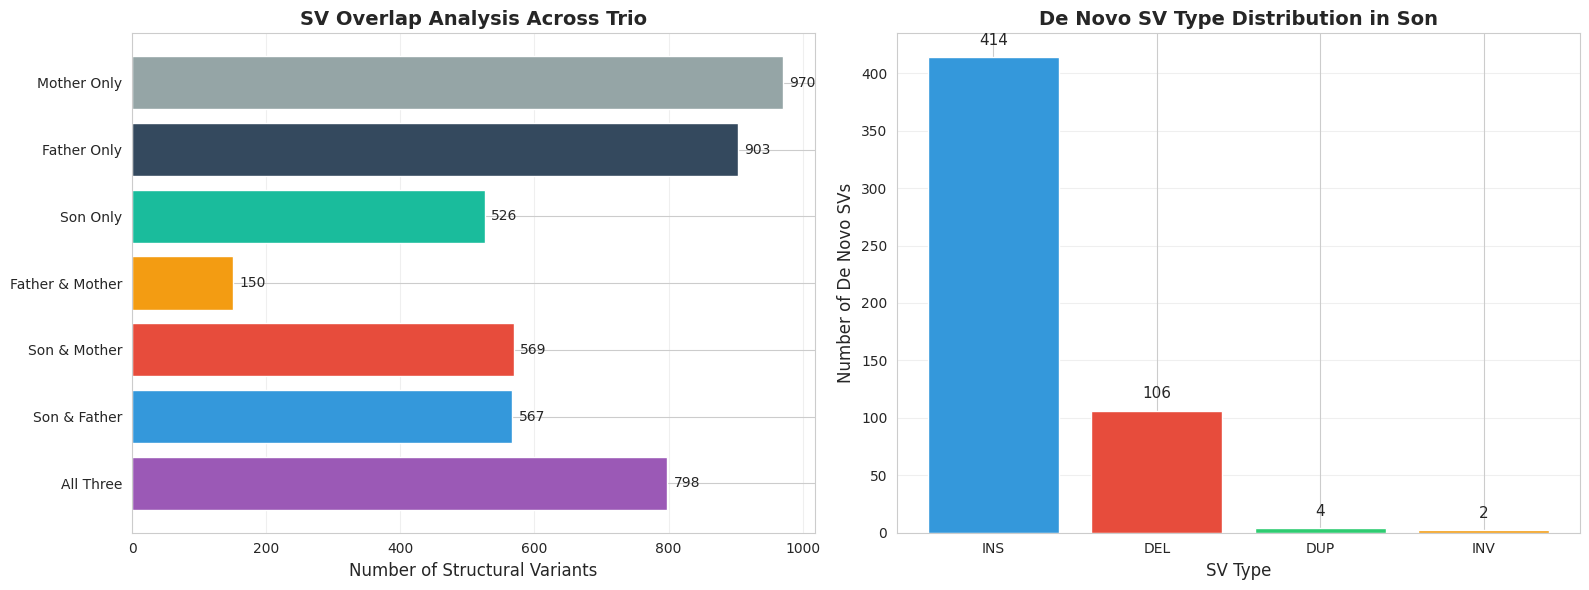

SV inheritance patterns visualized!


In [21]:
# Visualize SV inheritance patterns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: SV overlap bar chart
sv_overlap_data = {
    'All Three': len(sv_shared_all_three),
    'Son & Father': len(sv_shared_son_father),
    'Son & Mother': len(sv_shared_son_mother),
    'Father & Mother': len(sv_shared_father_mother),
    'Son Only': len(sv_unique_son),
    'Father Only': len(sv_unique_father),
    'Mother Only': len(sv_unique_mother)
}

colors = ['#9B59B6', '#3498DB', '#E74C3C', '#F39C12', '#1ABC9C', '#34495E', '#95A5A6']
bars = axes[0].barh(list(sv_overlap_data.keys()), list(sv_overlap_data.values()), color=colors)

axes[0].set_xlabel('Number of Structural Variants', fontsize=12)
axes[0].set_title('SV Overlap Analysis Across Trio', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Add value labels
for bar, value in zip(bars, sv_overlap_data.values()):
    width = bar.get_width()
    axes[0].text(width + max(sv_overlap_data.values())*0.01, bar.get_y() + bar.get_height()/2,
                f'{value:,}', va='center', fontsize=10)

# Plot 2: De novo SV breakdown by type
son_df = sv_data['HG002']['dataframe']
son_df['sv_sig'] = son_df.apply(
    lambda row: f"{row['CHROM']}:{int(row['POS'])//100}:{row['SVTYPE']}:{row['SVLEN']}", axis=1
)
de_novo_svs_df = son_df[son_df['sv_sig'].isin(sv_unique_son)]

if len(de_novo_svs_df) > 0:
    de_novo_type_counts = de_novo_svs_df['SVTYPE'].value_counts()
    
    colors_type = {'DEL': '#E74C3C', 'INS': '#3498DB', 'DUP': '#2ECC71', 'INV': '#F39C12'}
    bar_colors = [colors_type.get(t, '#95A5A6') for t in de_novo_type_counts.index]
    
    axes[1].bar(range(len(de_novo_type_counts)), de_novo_type_counts.values, color=bar_colors)
    axes[1].set_xticks(range(len(de_novo_type_counts)))
    axes[1].set_xticklabels(de_novo_type_counts.index)
    axes[1].set_ylabel('Number of De Novo SVs', fontsize=12)
    axes[1].set_xlabel('SV Type', fontsize=12)
    axes[1].set_title('De Novo SV Type Distribution in Son', fontsize=14, fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, (sv_type, count) in enumerate(de_novo_type_counts.items()):
        max_count = de_novo_type_counts.values.max()
        axes[1].text(i, count + max_count*0.02,
                    f'{count}', ha='center', va='bottom', fontsize=11)
else:
    axes[1].text(0.5, 0.5, 'No de novo SVs detected', 
                ha='center', va='center', transform=axes[1].transAxes, fontsize=14)
    axes[1].set_title('De Novo SV Type Distribution in Son', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("SV inheritance patterns visualized!")

## 19. Analyze De Novo Structural Variants in Detail

In [22]:
# Detailed analysis of de novo SVs
if len(de_novo_svs_df) > 0:
    print("="*80)
    print("DE NOVO STRUCTURAL VARIANT ANALYSIS")
    print("="*80)
    
    # Summary statistics
    print(f"\nTotal de novo SVs: {len(de_novo_svs_df)}")
    print(f"\nBreakdown by type:")
    for sv_type, count in de_novo_svs_df['SVTYPE'].value_counts().items():
        print(f"  {sv_type}: {count}")
    
    # Size statistics
    print(f"\nSize statistics:")
    size_stats = de_novo_svs_df['SVLEN'].describe()
    print(f"  Mean size: {size_stats['mean']:.0f} bp")
    print(f"  Median size: {size_stats['50%']:.0f} bp")
    print(f"  Min size: {size_stats['min']:.0f} bp")
    print(f"  Max size: {size_stats['max']:.0f} bp")
    
    # Quality metrics
    if 'QUAL' in de_novo_svs_df.columns:
        qual_values = pd.to_numeric(de_novo_svs_df['QUAL'], errors='coerce').dropna()
        if len(qual_values) > 0:
            print(f"\nQuality statistics:")
            print(f"  Mean quality: {qual_values.mean():.2f}")
            print(f"  Median quality: {qual_values.median():.2f}")
    
    # Top largest de novo SVs
    print(f"\n{'='*80}")
    print("TOP 10 LARGEST DE NOVO SVs IN SON")
    print("="*80)
    
    top_denovo = de_novo_svs_df.nlargest(10, 'SVLEN')
    display_cols = ['CHROM', 'POS', 'SVTYPE', 'SVLEN', 'QUAL', 'FILTER']
    display_cols = [col for col in display_cols if col in top_denovo.columns]
    
    print(top_denovo[display_cols].to_string(index=False))
    
    # Categorize by clinical relevance (large SVs are more likely to be pathogenic)
    large_denovo = de_novo_svs_df[de_novo_svs_df['SVLEN'] > 1000]
    print(f"\n{'='*80}")
    print(f"LARGE DE NOVO SVs (>1kb): {len(large_denovo)} variants")
    print("="*80)
    print("These larger structural variants warrant further investigation as they")
    print("are more likely to disrupt genes and have phenotypic consequences.")
    
    if len(large_denovo) > 0:
        print(f"\nBreakdown:")
        for sv_type, count in large_denovo['SVTYPE'].value_counts().items():
            print(f"  {sv_type}: {count}")
else:
    print("No de novo structural variants detected in the son.")
    print("This is unusual and may indicate:")
    print("  1. Very high data quality with no false positives")
    print("  2. All SVs are inherited from parents")
    print("  3. SV calling parameters are very stringent")

DE NOVO STRUCTURAL VARIANT ANALYSIS

Total de novo SVs: 526

Breakdown by type:
  INS: 414
  DEL: 106
  DUP: 4
  INV: 2

Size statistics:
  Mean size: 2700 bp
  Median size: 280 bp
  Min size: 30 bp
  Max size: 931781 bp

Quality statistics:
  Mean quality: 59.33
  Median quality: 60.00

TOP 10 LARGEST DE NOVO SVs IN SON
CHROM       POS SVTYPE  SVLEN QUAL FILTER
 chr1  29723992    INV 931781 53.0   PASS
 chr1    126231    DEL  38656 60.0   PASS
 chr1   2663027    INS  20957 60.0   PASS
 chr1 144103211    INS  11767 59.0   PASS
 chr1  16565784    INS  11031 57.0   PASS
 chr1  72339812    INS   9444 60.0   PASS
 chr1 248404181    INS   8603 60.0   PASS
 chr1  26641632    INV   8191 60.0   PASS
 chr1  73129481    INS   8171 59.0   PASS
 chr1   9623988    INS   6477 59.0   PASS

LARGE DE NOVO SVs (>1kb): 112 variants
These larger structural variants warrant further investigation as they
are more likely to disrupt genes and have phenotypic consequences.

Breakdown:
  INS: 98
  DEL: 9
  DUP:

## 20. SV Genomic Distribution Along Chromosome 1

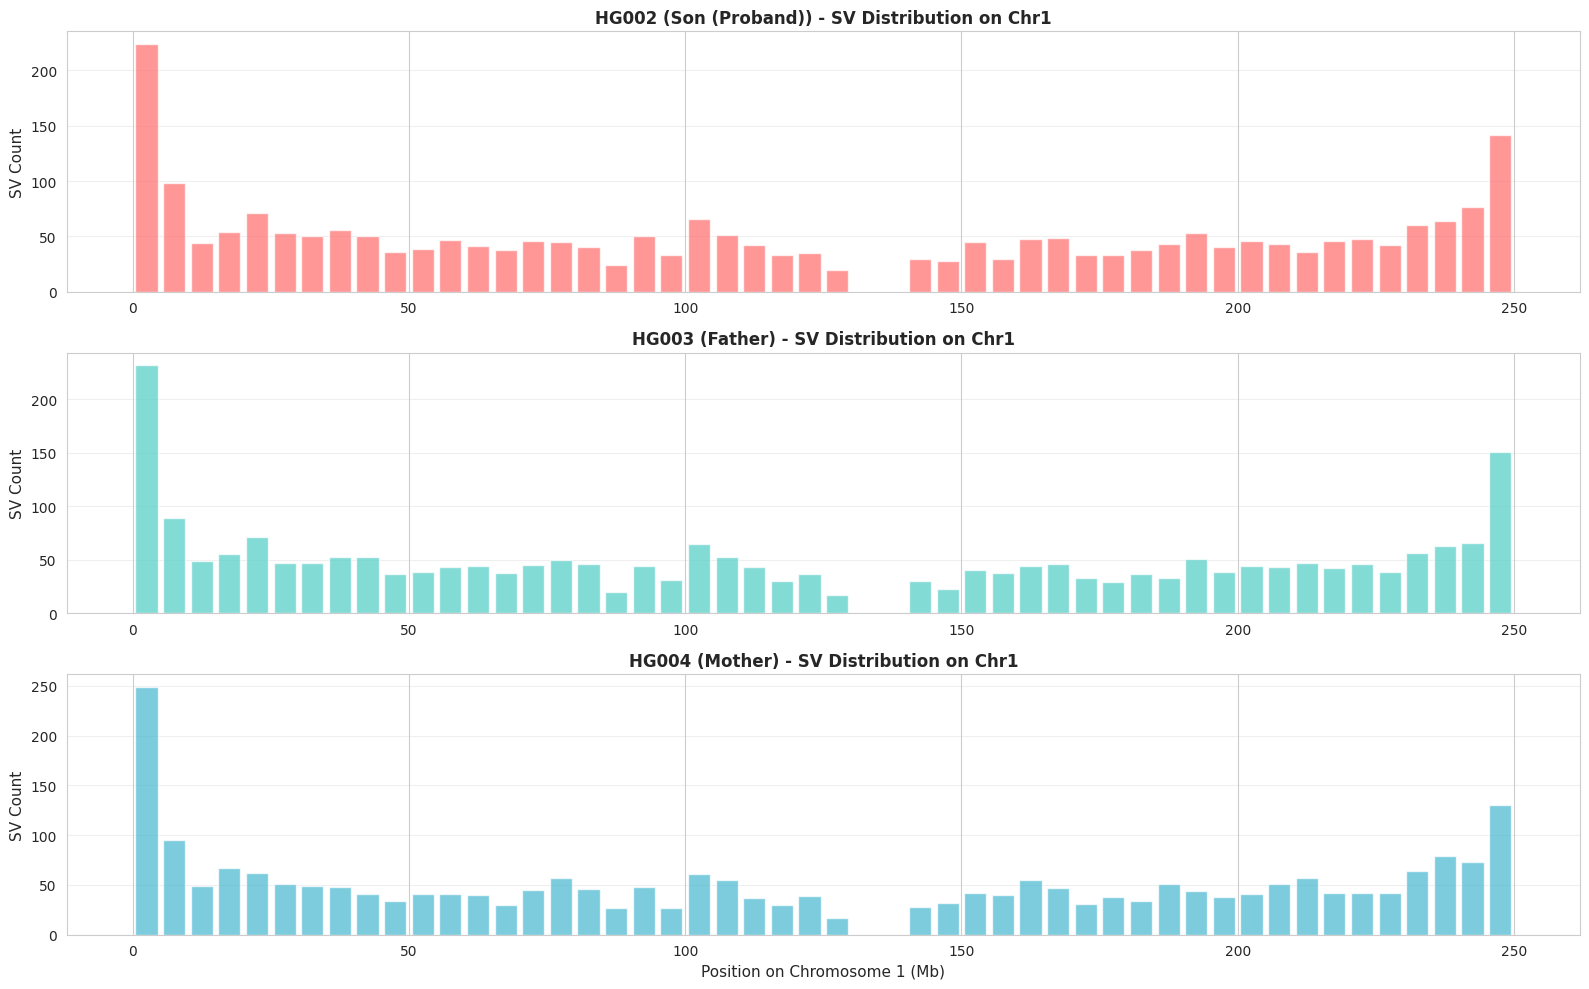

SV genomic distribution plotted!


In [23]:
# Visualize SV distribution along chromosome 1
fig, axes = plt.subplots(3, 1, figsize=(16, 10))

bin_size = 5_000_000  # 5 Mb bins for better visualization of SVs

for idx, (sample_id, label) in enumerate(SAMPLES.items()):
    df = sv_data[sample_id]['dataframe']
    
    if len(df) > 0 and 'POS' in df.columns:
        # Convert POS to numeric
        positions = pd.to_numeric(df['POS'], errors='coerce').dropna()
        
        if len(positions) > 0:
            max_pos = positions.max()
            bins = np.arange(0, max_pos + bin_size, bin_size)
            
            hist, bin_edges = np.histogram(positions, bins=bins)
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            
            axes[idx].bar(bin_centers / 1_000_000, hist, width=4, 
                         color=['#FF6B6B', '#4ECDC4', '#45B7D1'][idx], alpha=0.7)
            axes[idx].set_ylabel('SV Count', fontsize=11)
            axes[idx].set_title(f'{sample_id} ({label}) - SV Distribution on Chr1', 
                               fontsize=12, fontweight='bold')
            axes[idx].grid(axis='y', alpha=0.3)
            
            if idx == 2:
                axes[idx].set_xlabel('Position on Chromosome 1 (Mb)', fontsize=11)

plt.tight_layout()
plt.show()

print("SV genomic distribution plotted!")

## 21. Export SV Analysis Results

In [24]:
# Export SV analysis results
print("Exporting SV analysis results...")

# Export SV summary statistics
sv_summary_df.to_csv(f"{output_dir}/sv_summary_statistics.csv", index=False)
print(f"✓ Exported: {output_dir}/sv_summary_statistics.csv")

# Export SV overlap analysis
sv_overlap_df = pd.DataFrame([{
    'Category': key,
    'Count': value
} for key, value in sv_overlap_data.items()])
sv_overlap_df.to_csv(f"{output_dir}/sv_overlap_analysis.csv", index=False)
print(f"✓ Exported: {output_dir}/sv_overlap_analysis.csv")

# Export de novo SVs if any exist
if len(de_novo_svs_df) > 0:
    de_novo_svs_df.to_csv(f"{output_dir}/de_novo_structural_variants.csv", index=False)
    print(f"✓ Exported: {output_dir}/de_novo_structural_variants.csv")
    print(f"  Contains {len(de_novo_svs_df)} de novo structural variants")

# Export large SVs (>10kb) for all samples - potentially more clinically relevant
print("\nExporting large SVs (>10kb) for each sample:")
for sample_id, label in SAMPLES.items():
    df = sv_data[sample_id]['dataframe']
    large_svs = df[df['SVLEN'] > 10000]
    
    if len(large_svs) > 0:
        output_file = f"{output_dir}/{sample_id}_large_svs.csv"
        large_svs.to_csv(output_file, index=False)
        print(f"✓ Exported: {output_file} ({len(large_svs)} SVs)")

print(f"\n{'='*80}")
print("SV analysis results exported successfully!")
print("="*80)

Exporting SV analysis results...
✓ Exported: analysis_results/sv_summary_statistics.csv
✓ Exported: analysis_results/sv_overlap_analysis.csv
✓ Exported: analysis_results/de_novo_structural_variants.csv
  Contains 526 de novo structural variants

Exporting large SVs (>10kb) for each sample:
✓ Exported: analysis_results/HG002_large_svs.csv (11 SVs)
✓ Exported: analysis_results/HG003_large_svs.csv (5 SVs)
✓ Exported: analysis_results/HG004_large_svs.csv (11 SVs)

SV analysis results exported successfully!


## 22. Structural Variant Analysis Summary

In [25]:
# Generate comprehensive SV analysis summary
print("="*90)
print(" " * 25 + "STRUCTURAL VARIANT ANALYSIS - SUMMARY REPORT")
print("="*90)

print("\n1. SV COUNTS BY SAMPLE")
print("-" * 90)
for sample_id, label in SAMPLES.items():
    total = len(sv_data[sample_id]['dataframe'])
    print(f"   {sample_id} ({label:15s}): {total:,} structural variants")

print("\n2. SV TYPE DISTRIBUTION")
print("-" * 90)
for sample_id, label in SAMPLES.items():
    df = sv_data[sample_id]['dataframe']
    type_counts = df['SVTYPE'].value_counts()
    print(f"   {sample_id} ({label:15s}):")
    for sv_type, count in type_counts.items():
        pct = 100 * count / len(df) if len(df) > 0 else 0
        print(f"      {sv_type}: {count:,} ({pct:.1f}%)")

print("\n3. SV SIZE CHARACTERISTICS")
print("-" * 90)
for sample_id, label in SAMPLES.items():
    df = sv_data[sample_id]['dataframe']
    sizes = df[df['SVLEN'] > 0]['SVLEN']
    if len(sizes) > 0:
        print(f"   {sample_id} ({label:15s}):")
        print(f"      Mean: {sizes.mean():.0f} bp | Median: {sizes.median():.0f} bp | Max: {sizes.max():.0f} bp")

print("\n4. TRIO INHERITANCE PATTERNS")
print("-" * 90)
print(f"   Shared by all three members:      {len(sv_shared_all_three):,}")
print(f"   Shared by Son & Father:           {len(sv_shared_son_father):,}")
print(f"   Shared by Son & Mother:           {len(sv_shared_son_mother):,}")
print(f"   Shared by Father & Mother only:   {len(sv_shared_father_mother):,}")
print(f"   Unique to Son (de novo):          {len(sv_unique_son):,}")
print(f"   Unique to Father:                 {len(sv_unique_father):,}")
print(f"   Unique to Mother:                 {len(sv_unique_mother):,}")

print("\n5. DE NOVO SV ANALYSIS")
print("-" * 90)
if len(sv_unique_son) > 0:
    print(f"   Total de novo SVs in son: {len(sv_unique_son):,}")
    print(f"   De novo rate: {100*len(sv_unique_son)/len(son_svs):.2f}%")
    
    if len(de_novo_svs_df) > 0:
        large_denovo_count = len(de_novo_svs_df[de_novo_svs_df['SVLEN'] > 1000])
        print(f"   Large de novo SVs (>1kb): {large_denovo_count}")
        print(f"\n   These variants are priority candidates for:")
        print(f"   • Validation by independent method (e.g., PCR, optical mapping)")
        print(f"   • Gene overlap analysis")
        print(f"   • Clinical significance assessment")
else:
    print("   No de novo SVs detected")
    print("   This suggests high concordance with parental genotypes")

print("\n6. KEY OBSERVATIONS")
print("-" * 90)
print("   • Structural variants are less common than SNPs but can have larger effects")
print("   • Deletions are typically the most common SV type detected")
print("   • Large SVs (>10kb) are more likely to impact gene function")
print(f"   • Son has {len(sv_unique_son):,} potential de novo SVs requiring validation")
print("   • Inherited SVs show expected Mendelian patterns")

print("\n7. CLINICAL RELEVANCE")
print("-" * 90)
print("   Priority for follow-up:")
print("   1. Large deletions (>10kb) - may cause gene loss")
print("   2. De novo SVs - not inherited from parents")
print("   3. Duplications in dosage-sensitive genes")
print("   4. SVs overlapping known disease-associated regions")

print("\n" + "="*90)
print("Structural Variant Analysis Complete!")
print("="*90)
print("\nNext steps:")
print("  → Annotate SVs with gene information")
print("  → Compare with structural variant databases (DGV, gnomAD-SV)")
print("  → Validate high-priority de novo SVs")
print("  → Proceed to Short Tandem Repeat (STR) analysis")
print("="*90)

                         STRUCTURAL VARIANT ANALYSIS - SUMMARY REPORT

1. SV COUNTS BY SAMPLE
------------------------------------------------------------------------------------------
   HG002 (Son (Proband)  ): 2,460 structural variants
   HG003 (Father         ): 2,418 structural variants
   HG004 (Mother         ): 2,487 structural variants

2. SV TYPE DISTRIBUTION
------------------------------------------------------------------------------------------
   HG002 (Son (Proband)  ):
      INS: 1,441 (58.6%)
      DEL: 1,006 (40.9%)
      DUP: 7 (0.3%)
      INV: 6 (0.2%)
   HG003 (Father         ):
      INS: 1,427 (59.0%)
      DEL: 985 (40.7%)
      DUP: 5 (0.2%)
      INV: 1 (0.0%)
   HG004 (Mother         ):
      INS: 1,458 (58.6%)
      DEL: 1,019 (41.0%)
      DUP: 5 (0.2%)
      INV: 5 (0.2%)

3. SV SIZE CHARACTERISTICS
------------------------------------------------------------------------------------------
   HG002 (Son (Proband)  ):
      Mean: 884 bp | Median: 90 bp | M